Турчин 1223
## Урок 2. Профилирование пользователей. <br> Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)

<hr>
<font color= broun size=3, >
1*<br>
Самостоятельно повторить tfidf (документация <br>https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
    <hr>

<hr>
<font color= broun size=3, >
2<br>
Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог)
    <hr>

## Пример новостной портал

Представим, что мы - компания-агрегатор новостей (новостной портал). И мы хотим построить модель прогнозирования оттока клиентов.
У нас есть:
1. читатели
2. новости
Для каждого пользователя мы можем за какой-то период (например, 1 день) достать из базы данных список прочитанных им новостей.
Для каждой новости мы можем вытащить текст и метаинформацию.
##Нужно построить модель прогнозирования оттока. 

Нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

In [1]:
import pandas as pd

In [2]:
# Скачал новости "articles.csv" и загрузил в датафрейм
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
# Скачал сведения по юзерам, и номерам статей, которые они читали "users_articles.csv" и загрузил в датафрейм
users = pd.read_csv("users_articles.csv")
print(news.shape)
users.head(3)

(27000, 2)


,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


### 1. Получаем векторные представления новостей

In [4]:
!pip install razdel pymorphy2 pyLDAvis

In [5]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [6]:
# предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор

Не все слова равны, не все слова одинаково работают. К примеру, союзы и предлоги в нашей задачи никак не помогут, поэтому можем их выкидывать. (*Но в задачах оценки стиля, к примеру, такие слова будут очень полезны*)

In [7]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stavr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
stopword_ru = stopwords.words('russian')

In [9]:
# расширим стопслова
with open('c:\\Users\\stavr\\YandexDisk\\00_Education_2021\\01_Analytics\\IV_четверть\\01_Машинное_обучение_в_бизнесе\\02_Less_2_ML_Business\\hw_2\\stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [10]:
def clean_text(text):
    '''
    очистка текста
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [147]:
news['title'].iloc[:6].apply(lambda x: clean_text(x))

0    'заместитель' 'председатель' 'правительство' '...
1    'матч' 'финал' 'кубок' 'россия' 'футбол' 'прио...
2    'форвард' 'авангард' 'томаш' 'заборский' 'прок...
3    'главный' 'тренер' 'кубань' 'юрий' 'красножани...
4    'решение' 'попечительский' 'совет' 'владивосто...
5    'ио' 'главное' 'тренер' 'вячеслав' 'буцай' 'пр...
Name: title, dtype: object

In [12]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [16]:
%%time
from tqdm import tqdm
tqdm.pandas()

# Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x))

Wall time: 25.2 s


In [17]:
news['title'].iloc[:10]

0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
2    форвард авангарда томаш заборский прокомментир...
3    главный тренер кубани юрий красножан прокоммен...
4    решением попечительского совета владивостокско...
5    ио главного тренера вячеслав буцаев прокоммент...
6    запорожский металлург дома потерпел разгромное...
7    сборная сша одержала победу над австрией со сч...
8    бывший защитник сборной россии дарюс каспарайт...
9    полузащитник цска зоран тошич после победы над...
Name: title, dtype: object

In [21]:
news['title'].iloc[:6].apply(lambda x: lemmatization(x))

0    [заместитель, председатель, правительство, рф,...
1    [матч, финал, кубок, россия, футбол, приостано...
2    [форвард, авангард, томаш, заборский, прокомме...
3    [главный, тренер, кубань, юрий, красножанин, п...
4    [решение, попечительский, совет, владивостокск...
5    [ио, главное, тренер, вячеслав, буцай, прокомм...
Name: title, dtype: object

In [22]:
%%time
# Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x))

  0%|          | 0/27000 [03:36<?, ?it/s]


Wall time: 2min 17s


А теперь в 3 строчки обучим нашу модель

In [23]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [30]:
# common_dictionary.doc2bow(['Мама', 'мыла', 'мыла ', 'мыла', 'раму', 'Раму'], allow_update=True)

[(135723, 1), (135724, 2), (135725, 1), (135726, 1), (135727, 1)]

### Запускаем обучение

In [31]:
N_topic = 15

In [32]:
%%time
from gensim.models import LdaModel

# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

Wall time: 26.1 s


In [34]:
%%time
from gensim.models import LdaModel

# Обучаем модель на корпусе (3 прогона)
lda_3 = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary, passes=3)

Wall time: 1min 12s


In [105]:
from gensim.test.utils import datapath

# Сохраняем модель на диск
temp_file = datapath("model.lda")
lda.save(temp_file)

In [36]:
from gensim.test.utils import datapath

# Сохраняем модель на диск
temp_file = datapath("model_3.lda")
lda_3.save(temp_file)

In [106]:
# Загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [151]:
# Загружаем обученную модель с диска
lda_3 = LdaModel.load("c:\\Users\\stavr\\anaconda3\\Lib\\site-packages\\gensim\\test\\test_data\\model_3.lda")

In [107]:
# Создаем новый корпус документов, которые раньше не видели
other_texts = list(news['title'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(6, 0.038374342), (7, 0.059933122), (8, 0.2642045), (11, 0.6207849)]

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [108]:
x = lda.show_topics(num_topics=N_topic, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: газ район вода море экипаж рак остров
topic_1: год это россия украина компания который мочь
topic_2: кожа реконструкция актёр курение акционер лесной медведев
topic_3: который научный работа москва наука день область
topic_4: учёный журнал операция который земля помощь день
topic_5: финал пионер грачёв андерсон белов никифоров восстановительный
topic_6: президент путин владимир россия лидер встреча долг
topic_7: сша американский ракета космический корабль трамп космос
topic_8: это который мочь человек всё весь свой
topic_9: ребёнок дело суд женщина год мужчина человек
topic_10: афганистан кладбище похороны норматив югра миллер персона
topic_11: обращение рейс команда игра физика клуб сезон
topic_12: погибнуть космонавт корея опасаться казахстан армения эстония
topic_13: который год россия это российский также отмечать
topic_14: год исследование тыс стать человек который это


Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [109]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [110]:
get_lda_vector(lda, news['title'].iloc[17])

array([0.        , 0.        , 0.        , 0.        , 0.30500942,
       0.        , 0.07151563, 0.        , 0.        , 0.        ,
       0.        , 0.60712832, 0.        , 0.        , 0.        ])

In [111]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

Wall time: 20.4 s


,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,6,0.0,0.108055,0.0,0.663488,0.000000,0.012893,0.016343,0.000000,0.000000,0.063447,0.0,0.127509,0.0,0.000000,0.0
1,4896,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.609319,0.0,0.368991,0.0
2,4897,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.038375,0.059934,0.264199,0.000000,0.0,0.620788,0.0,0.000000,0.0
3,4898,0.0,0.274600,0.0,0.000000,0.186775,0.000000,0.000000,0.000000,0.284643,0.000000,0.0,0.245109,0.0,0.000000,0.0
4,4899,0.0,0.000000,0.0,0.562680,0.194720,0.000000,0.053706,0.000000,0.000000,0.000000,0.0,0.168481,0.0,0.000000,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [112]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [113]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [114]:
doc_dict[293672]

array([0.05579808, 0.17387231, 0.        , 0.33568358, 0.        ,
       0.        , 0.        , 0.        , 0.05920845, 0.        ,
       0.        , 0.        , 0.        , 0.06842954, 0.29395384])

In [115]:
# Получаем векторое описание пользователя по его новостям 
# user_articles_list - список новостей
# doc_dict - словарь описание документа 
# param - для выбора агрегирующей функции

def get_user_embedding(user_articles_list, doc_dict, param):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     print(user_vector)
    user_vector = param(user_vector, 0)  # можно не среднее
    return user_vector

In [116]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [117]:
# Пример: пользователь... смотрел новости :'[323329, 321961, 324743, 323186, 324632, 474690]'
user_articles_list = users['articles'].iloc[33]
get_user_embedding(user_articles_list, doc_dict, np.mean)

array([0.00897791, 0.11700506, 0.        , 0.07388107, 0.01988334,
       0.00172457, 0.12529358, 0.04487109, 0.10043951, 0.10889115,
       0.00833784, 0.00192979, 0.        , 0.30652093, 0.07389516])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [118]:
param = np.mean

In [119]:
%%time
#  Усредненные тематики, которые читали пользователи
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, param))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

Wall time: 333 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,u105138,0.019401,0.077257,0.00532,0.241292,0.009253,0.000000,0.060430,0.017506,0.107060,0.037903,0.0,0.009079,0.000000,0.252248,0.145074
1,u108690,0.011513,0.212401,0.00000,0.094692,0.020547,0.000000,0.097748,0.028119,0.165468,0.088944,0.0,0.007323,0.000000,0.228163,0.041305
2,u108339,0.034254,0.074866,0.00000,0.160129,0.046040,0.002159,0.102683,0.009402,0.063801,0.084804,0.0,0.005159,0.004433,0.360713,0.041587


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [120]:
# подгрузили данные по оттоку
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [121]:
# соединили метку оттока с векторными данными представления пользователя 
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,churn
0,u105138,0.019401,0.077257,0.00532,0.241292,0.009253,0.000000,0.060430,0.017506,0.107060,0.037903,0.0,0.009079,0.000000,0.252248,0.145074,0
1,u108690,0.011513,0.212401,0.00000,0.094692,0.020547,0.000000,0.097748,0.028119,0.165468,0.088944,0.0,0.007323,0.000000,0.228163,0.041305,1
2,u108339,0.034254,0.074866,0.00000,0.160129,0.046040,0.002159,0.102683,0.009402,0.063801,0.084804,0.0,0.005159,0.004433,0.360713,0.041587,1


In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [123]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [124]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [125]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:20]

array([0.23762416, 0.01262121, 0.48017555, 0.16656124, 0.0202382 ,
       0.03736244, 0.12190111, 0.00975405, 0.03875444, 0.12361736,
       0.09098564, 0.26311468, 0.00914595, 0.17908175, 0.0582398 ,
       0.20530535, 0.02288462, 0.02640909, 0.00306835, 0.03704437])

In [126]:
metrics_df = pd.DataFrame(columns=['model', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC'])
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC


### Рассчитаем Precision, Recall, F_score

In [127]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

In [128]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.2816599749021023, F-Score=0.714, Precision=0.674, Recall=0.759


In [129]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9580673294959009

In [130]:
metrics_df = metrics_df.append({
    'model': param.__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

metrics_df

<ipython-input-130-01736952d766>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC
0,mean,0.28166,0.714012,0.673913,0.759184,0.958067


#### ВОЗЬМЕМ МЕДИАНУ

In [131]:
param = np.median

In [132]:
%%time
#  Усредненные тематики, которые читали пользователи
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, param))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

Wall time: 593 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,u105138,0.008825,0.012827,0.0,0.201795,0.000000,0.0,0.047732,0.0,0.104319,0.000000,0.0,0.0,0.0,0.217160,0.114629
1,u108690,0.007291,0.209459,0.0,0.082578,0.018318,0.0,0.066070,0.0,0.125272,0.051756,0.0,0.0,0.0,0.226608,0.006215
2,u108339,0.029271,0.043615,0.0,0.090791,0.023213,0.0,0.011673,0.0,0.046680,0.074335,0.0,0.0,0.0,0.342004,0.023573


In [133]:
# соединили метку оттока с векторными данными представления пользователя 
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,churn
0,u105138,0.008825,0.012827,0.0,0.201795,0.000000,0.0,0.047732,0.0,0.104319,0.000000,0.0,0.0,0.0,0.217160,0.114629,0
1,u108690,0.007291,0.209459,0.0,0.082578,0.018318,0.0,0.066070,0.0,0.125272,0.051756,0.0,0.0,0.0,0.226608,0.006215,1
2,u108339,0.029271,0.043615,0.0,0.090791,0.023213,0.0,0.011673,0.0,0.046680,0.074335,0.0,0.0,0.0,0.342004,0.023573,1


In [134]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [135]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [136]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:20]

array([0.14403319, 0.01434156, 0.64998109, 0.27980233, 0.01724899,
       0.04135327, 0.05842704, 0.01418333, 0.15731644, 0.08201595,
       0.04889653, 0.07138855, 0.01255454, 0.0857185 , 0.05711373,
       0.25544915, 0.01836695, 0.00995668, 0.00161734, 0.06278786])

In [137]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.23342910512511406, F-Score=0.708, Precision=0.606, Recall=0.853


In [138]:
metrics_df = metrics_df.append({
    'model': param.__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

metrics_df

<ipython-input-138-01736952d766>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC
0,mean,0.28166,0.714012,0.673913,0.759184,0.958067
1,median,0.233429,0.708475,0.605797,0.853061,0.958067


#### ВОЗЬМЕМ max

In [139]:
param = np.max

In [140]:
%%time
#  Усредненные тематики, которые читали пользователи
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, param))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

Wall time: 260 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,u105138,0.055798,0.264019,0.031919,0.463977,0.055519,0.000000,0.151741,0.053396,0.280375,0.139305,0.0,0.054471,0.000000,0.437343,0.347230
1,u108690,0.035052,0.414262,0.000000,0.175407,0.044908,0.000000,0.272881,0.106672,0.365140,0.285176,0.0,0.043941,0.000000,0.447913,0.170180
2,u108339,0.083747,0.284474,0.000000,0.380179,0.116703,0.012953,0.417366,0.034421,0.133590,0.184004,0.0,0.019178,0.014778,0.555316,0.105613


In [141]:
# соединили метку оттока с векторными данными представления пользователя 
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,churn
0,u105138,0.055798,0.264019,0.031919,0.463977,0.055519,0.000000,0.151741,0.053396,0.280375,0.139305,0.0,0.054471,0.000000,0.437343,0.347230,0
1,u108690,0.035052,0.414262,0.000000,0.175407,0.044908,0.000000,0.272881,0.106672,0.365140,0.285176,0.0,0.043941,0.000000,0.447913,0.170180,1
2,u108339,0.083747,0.284474,0.000000,0.380179,0.116703,0.012953,0.417366,0.034421,0.133590,0.184004,0.0,0.019178,0.014778,0.555316,0.105613,1


In [142]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [143]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [144]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:20]

array([0.16871555, 0.0189222 , 0.62797263, 0.17875648, 0.02180951,
       0.01163868, 0.11195908, 0.001386  , 0.0118752 , 0.12885722,
       0.01832897, 0.1686537 , 0.00447427, 0.16867152, 0.01484391,
       0.39761858, 0.01383226, 0.00100046, 0.01108999, 0.27895287])

In [145]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.30016397871021017, F-Score=0.687, Precision=0.606, Recall=0.792


In [146]:
metrics_df = metrics_df.append({
    'model': param.__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

metrics_df

<ipython-input-146-01736952d766>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC
0,mean,0.28166,0.714012,0.673913,0.759184,0.958067
1,median,0.233429,0.708475,0.605797,0.853061,0.958067
2,amax,0.300164,0.686726,0.60625,0.791837,0.958067


### ДЛЯ МОДЕЛИ с ТРЕМЯ ПРОГОНАМИ:

In [245]:
# Загружаем обученную модель с диска
lda_1 = LdaModel.load("c:\\Users\\stavr\\anaconda3\\Lib\\site-packages\\gensim\\test\\test_data\\model.lda")

In [246]:
# Создаем новый корпус документов, которые раньше не видели
other_texts = list(news['title'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda_1[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(6, 0.038374342), (7, 0.059933122), (8, 0.2642045), (11, 0.6207849)]

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [247]:
x = lda_1.show_topics(num_topics=N_topic, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: газ район вода море экипаж рак остров
topic_1: год это россия украина компания который мочь
topic_2: кожа реконструкция актёр курение акционер лесной медведев
topic_3: который научный работа москва наука день область
topic_4: учёный журнал операция который земля помощь день
topic_5: финал пионер грачёв андерсон белов никифоров восстановительный
topic_6: президент путин владимир россия лидер встреча долг
topic_7: сша американский ракета космический корабль трамп космос
topic_8: это который мочь человек всё весь свой
topic_9: ребёнок дело суд женщина год мужчина человек
topic_10: афганистан кладбище похороны норматив югра миллер персона
topic_11: обращение рейс команда игра физика клуб сезон
topic_12: погибнуть космонавт корея опасаться казахстан армения эстония
topic_13: который год россия это российский также отмечать
topic_14: год исследование тыс стать человек который это


Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [157]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [248]:
get_lda_vector(lda_1, news['title'].iloc[17])

array([0.        , 0.        , 0.        , 0.        , 0.30500942,
       0.        , 0.07151563, 0.        , 0.        , 0.        ,
       0.        , 0.60712832, 0.        , 0.        , 0.        ])

In [249]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda_3, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

Wall time: 20.2 s


,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,6,0.0,0.10813,0.0,0.663853,0.000000,0.012891,0.016362,0.000000,0.000000,0.06352,0.0,0.127502,0.0,0.000000,0.0
1,4896,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.609300,0.0,0.369011,0.0
2,4897,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.038374,0.059933,0.264205,0.00000,0.0,0.620785,0.0,0.000000,0.0
3,4898,0.0,0.27459,0.0,0.000000,0.186776,0.000000,0.000000,0.000000,0.284652,0.00000,0.0,0.245109,0.0,0.000000,0.0
4,4899,0.0,0.00000,0.0,0.562670,0.194720,0.000000,0.053716,0.000000,0.000000,0.00000,0.0,0.168480,0.0,0.000000,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [250]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [251]:
# Получаем векторое описание пользователя по его новостям 
# user_articles_list - список новостей
# doc_dict - словарь описание документа 
# param - для выбора агрегирующей функции

def get_user_embedding(user_articles_list, doc_dict, param):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     print(user_vector)
    user_vector = param(user_vector, 0)  # можно не среднее
    return user_vector

In [252]:
param = np.mean

In [253]:
%%time
#  Усредненные тематики, которые читали пользователи
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, param))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

Wall time: 335 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,u105138,0.019401,0.077258,0.00532,0.241275,0.009253,0.000000,0.060429,0.017507,0.107062,0.037903,0.0,0.009079,0.000000,0.252258,0.145079
1,u108690,0.011513,0.212327,0.00000,0.094679,0.020548,0.000000,0.097760,0.028117,0.165568,0.088943,0.0,0.007324,0.000000,0.228141,0.041305
2,u108339,0.034253,0.074867,0.00000,0.160226,0.046040,0.002159,0.102668,0.009402,0.063829,0.084804,0.0,0.005159,0.004433,0.360600,0.041589


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [254]:
# подгрузили данные по оттоку
target = pd.read_csv("users_churn.csv")

In [255]:
# соединили метку оттока с векторными данными представления пользователя 
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,churn
0,u105138,0.019401,0.077258,0.00532,0.241275,0.009253,0.000000,0.060429,0.017507,0.107062,0.037903,0.0,0.009079,0.000000,0.252258,0.145079,0
1,u108690,0.011513,0.212327,0.00000,0.094679,0.020548,0.000000,0.097760,0.028117,0.165568,0.088943,0.0,0.007324,0.000000,0.228141,0.041305,1
2,u108339,0.034253,0.074867,0.00000,0.160226,0.046040,0.002159,0.102668,0.009402,0.063829,0.084804,0.0,0.005159,0.004433,0.360600,0.041589,1


In [256]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [257]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [258]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:20]

array([0.23799973, 0.01257844, 0.47984561, 0.16641816, 0.02021911,
       0.03737519, 0.11913826, 0.00973841, 0.03864921, 0.12365922,
       0.09081181, 0.26612615, 0.00914037, 0.17959379, 0.05789237,
       0.2053067 , 0.0228992 , 0.02639603, 0.00307181, 0.03705443])

In [259]:
metrics_df = pd.DataFrame(columns=['model', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC'])
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC


### Рассчитаем Precision, Recall, F_score

In [260]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

In [261]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.2814709009193603, F-Score=0.714, Precision=0.674, Recall=0.759


In [262]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9580301180301181

In [263]:
metrics_df = metrics_df.append({
    'model': param.__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

metrics_df

<ipython-input-263-01736952d766>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC
0,mean,0.281471,0.714012,0.673913,0.759184,0.95803


#### ВОЗЬМЕМ МЕДИАНУ

In [264]:
param = np.median

In [265]:
%%time
#  Усредненные тематики, которые читали пользователи
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, param))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

Wall time: 571 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,u105138,0.008825,0.012827,0.0,0.201725,0.000000,0.0,0.047732,0.0,0.104320,0.000000,0.0,0.0,0.0,0.217213,0.114630
1,u108690,0.007291,0.209465,0.0,0.082541,0.018321,0.0,0.066069,0.0,0.125263,0.051750,0.0,0.0,0.0,0.226523,0.006215
2,u108339,0.029271,0.043617,0.0,0.091085,0.023214,0.0,0.011673,0.0,0.046678,0.074335,0.0,0.0,0.0,0.341668,0.023575


In [266]:
# соединили метку оттока с векторными данными представления пользователя 
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,churn
0,u105138,0.008825,0.012827,0.0,0.201725,0.000000,0.0,0.047732,0.0,0.104320,0.000000,0.0,0.0,0.0,0.217213,0.114630,0
1,u108690,0.007291,0.209465,0.0,0.082541,0.018321,0.0,0.066069,0.0,0.125263,0.051750,0.0,0.0,0.0,0.226523,0.006215,1
2,u108339,0.029271,0.043617,0.0,0.091085,0.023214,0.0,0.011673,0.0,0.046678,0.074335,0.0,0.0,0.0,0.341668,0.023575,1


In [267]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [268]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [269]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:20]

array([0.1439444 , 0.01416505, 0.65022493, 0.27984746, 0.01737071,
       0.04138742, 0.05809442, 0.01414223, 0.15666477, 0.0817565 ,
       0.04888746, 0.07521915, 0.01251615, 0.08587505, 0.05712719,
       0.25517774, 0.01836641, 0.00992289, 0.00161686, 0.06314136])

In [270]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.23097561952537404, F-Score=0.709, Precision=0.605, Recall=0.857


In [271]:
metrics_df = metrics_df.append({
    'model': param.__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

metrics_df

<ipython-input-271-01736952d766>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC
0,mean,0.281471,0.714012,0.673913,0.759184,0.95803
1,median,0.230976,0.709459,0.605187,0.857143,0.95803


#### ВОЗЬМЕМ max

In [272]:
param = np.max

In [273]:
%%time
#  Усредненные тематики, которые читали пользователи
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, param))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

Wall time: 266 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,u105138,0.055797,0.264012,0.031919,0.463969,0.055519,0.000000,0.151741,0.053400,0.280386,0.139304,0.0,0.054471,0.000000,0.437350,0.347280
1,u108690,0.035052,0.414268,0.000000,0.175407,0.044912,0.000000,0.272953,0.106663,0.365139,0.285176,0.0,0.043941,0.000000,0.447924,0.170179
2,u108339,0.083746,0.284474,0.000000,0.380176,0.116703,0.012953,0.417279,0.034421,0.133766,0.184004,0.0,0.019177,0.014778,0.555312,0.105612


In [274]:
# соединили метку оттока с векторными данными представления пользователя 
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,churn
0,u105138,0.055797,0.264012,0.031919,0.463969,0.055519,0.000000,0.151741,0.053400,0.280386,0.139304,0.0,0.054471,0.000000,0.437350,0.347280,0
1,u108690,0.035052,0.414268,0.000000,0.175407,0.044912,0.000000,0.272953,0.106663,0.365139,0.285176,0.0,0.043941,0.000000,0.447924,0.170179,1
2,u108339,0.083746,0.284474,0.000000,0.380176,0.116703,0.012953,0.417279,0.034421,0.133766,0.184004,0.0,0.019177,0.014778,0.555312,0.105612,1


In [275]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [276]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [277]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:20]

array([0.16852139, 0.01889927, 0.62833709, 0.17933404, 0.02192744,
       0.0116653 , 0.10712825, 0.00138799, 0.0118863 , 0.12873098,
       0.0183369 , 0.16826078, 0.00449947, 0.16839671, 0.01486485,
       0.3976963 , 0.01387538, 0.00099578, 0.01110157, 0.27925504])

In [278]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.3002604775346288, F-Score=0.687, Precision=0.606, Recall=0.792


In [279]:
metrics_df = metrics_df.append({
    'model': param.__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

metrics_df

<ipython-input-279-01736952d766>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC
0,mean,0.281471,0.714012,0.673913,0.759184,0.95803
1,median,0.230976,0.709459,0.605187,0.857143,0.95803
2,amax,0.30026,0.686726,0.60625,0.791837,0.95803


*Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (взяв список новостей пользователя)
подсказка 1: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал
подсказка 2: нужен именно idf, как вес.

In [206]:
from sklearn.feature_extraction.text import TfidfVectorizer

'293672 293328 293001 293622 293126 1852'

In [209]:
users['articles_str'] = users['articles'].apply(lambda x: x.replace('[','').replace(']', '').replace(',', ''))
users['articles_str'].iloc[0]

'293672 293328 293001 293622 293126 1852'

In [227]:
tfidf = TfidfVectorizer()
tfidf.fit(users['articles_str'])

TfidfVectorizer()

In [229]:
users['articles_str']

0       293672 293328 293001 293622 293126 1852
1               3405 1739 2972 1158 1599 322665
2               1845 2009 2356 1424 2939 323389
3               5933 6186 5055 6977 5206 488389
4                707 1144 2532 2928 3133 324592
                         ...                   
7995     323918 323362 323704 323452 324291 251
7996            5532 5860 7755 7140 5182 488337
7997    322811 323898 321858 323345 323491 2193
7998            5436 6092 6891 7045 5320 487379
7999    294096 293759 294178 293544 293921 2909
Name: articles_str, Length: 8000, dtype: object

In [232]:
idf = pd.DataFrame({'article_id': tfidf.get_feature_names(), 'idf': tfidf.idf_})
idf

,article_id,idf
0,10,8.888710
1,100,7.907880
2,1000,8.041412
3,1001,8.888710
4,1002,8.888710
...,...,...
14776,995,8.377884
14777,996,8.195562
14778,997,8.601027
14779,998,9.294175


In [233]:
def get_user_embedding_idf(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    
    user_vector = np.zeros((len(user_articles_list), N_topic))
    for i, doc_id in enumerate(user_articles_list):
        try:
            weight = idf[idf['article_id'] == str(doc_id)]['idf'].values[0]
        except Exception as e:
            weight = 0
        user_vector[i] = doc_dict[doc_id] * weight

    user_vector = np.median(user_vector, axis=0)
    return user_vector

In [234]:
from tqdm import tqdm
tqdm.pandas()
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_idf(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,u105138,0.082023,0.119217,0.0,1.712073,0.000000,0.0,0.410539,0.0,0.914307,0.000000,0.0,0.0,0.0,1.877227,1.065621
1,u108690,0.064804,1.784165,0.0,0.681779,0.162796,0.0,0.581670,0.0,1.043416,0.460019,0.0,0.0,0.0,1.807850,0.055239
2,u108339,0.247903,0.386043,0.0,0.732869,0.199666,0.0,0.095671,0.0,0.413366,0.673872,0.0,0.0,0.0,2.768358,0.214367


In [235]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,churn
0,u105138,0.082023,0.119217,0.0,1.712073,0.000000,0.0,0.410539,0.0,0.914307,0.000000,0.0,0.0,0.0,1.877227,1.065621,0
1,u108690,0.064804,1.784165,0.0,0.681779,0.162796,0.0,0.581670,0.0,1.043416,0.460019,0.0,0.0,0.0,1.807850,0.055239,1
2,u108339,0.247903,0.386043,0.0,0.732869,0.199666,0.0,0.095671,0.0,0.413366,0.673872,0.0,0.0,0.0,2.768358,0.214367,1


In [236]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [237]:
LRM = LogisticRegression()
# обучим 
LRM.fit(X_train, y_train)

LogisticRegression()

In [238]:
# наши прогнозы для тестовой выборки
preds = LRM.predict_proba(X_test)[:, 1]
preds[:10]

array([3.76619865e-02, 4.26318561e-05, 9.46209540e-01, 1.80228205e-01,
       1.43207161e-04, 1.01179062e-03, 2.51238536e-03, 2.73029036e-06,
       7.40884317e-02, 4.00909591e-03])

In [239]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')    

Best Threshold=0.41985273076265245, F-Score=0.820, Precision=0.820, Recall=0.820


In [240]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9816314902029187

In [243]:
metrics_df_new = metrics_df.append({
    'model': 'idf_median',
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)


<ipython-input-243-ae6fd051acc1>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df_new = metrics_df.append({


5. Сформировать на выходе единую таблицу, сравнивающую качество 2/3 разных метода получения эмбедингов пользователей: median, max, idf_mean по метрикам roc_auc, precision, recall, f_score


In [242]:
metrics_df_new

,model,thresh,F-Score,Precision,Recall,ROC AUC
0,mean,0.281713,0.715385,0.676364,0.759184,0.958067
1,amax,0.300328,0.687943,0.60815,0.791837,0.958067
2,median,0.231523,0.709459,0.605187,0.857143,0.958067
3,amax,0.300328,0.687943,0.60815,0.791837,0.958067
4,idf_median,0.419853,0.820408,0.820408,0.820408,0.981631


In [ ]:
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Применение Tfidf - показало более высокий результат (опирается на "уникальные", редкие стаьи, которые качественно описывают пользователей).
Как ни странно "тройной прогон модели" не дал существенного прироста а метрике:

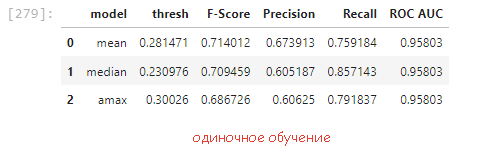

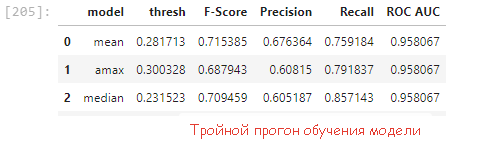

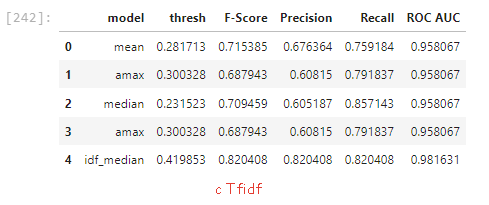



